# ***Clusters jerárquicos.***

## ***Universidad Central***





In [1]:
## Librerias a usar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
##
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering         ## Calcular Agrupamiento jerarquico
from scipy.cluster import hierarchy as sch                  ## Calcular Agrupamiento jerarquico
from scipy.spatial.distance import pdist, cdist             ## Distancias entre individuos.
##
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,6)
warnings.filterwarnings("ignore")
url_base = "https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/"

In [2]:
def improve_text_position(x):
  """"
      Esta función intercala las etiquetas en el texto de un plot en plotly
  """
  positions = ["top center", "bottom center"]
  return [positions[i % len(positions)] for i in range(len(x))]

In [3]:
def cluster_biplot(pca, dataframe, col_clusters, comp1=1, comp2=2, size_text=8 ):
  """
    Esta función construye el biplot de un PCA y muestra los cluster en el plano factorial.
    Input:  pca: Objeto pca que se usará para plotear los clusters.
            dataframe: pandas-DataFrame con el que se realizó el pca.
            col_cluster: Lista o pd.series con las etiquetas del asiganadas vía el método de cluster.
            comp1 = Componente en el eje x.
            comp2 = Compomente en el eje y
            size_text (int +): Tamáno dl texto para buscar evitar overlapping.
    Output: Biplot con los clusters.
  """ 
  ## Trabajo con pca y dataframe.
  comp_1, comp_2 = str(comp1), str(comp2) ## Strings de las compomentes a plotear.
  scaler, length = StandardScaler(), len(pca.explained_variance_)
  percent_var = pca.explained_variance_ratio_*100
  scaler.fit(dataframe)
  X_scaled = scaler.transform(dataframe)
  ##
  tmp = dataframe.copy()
  if tmp.index.name == None:        ## En caso que el DataFrame no tenga nombre para el índice.
    tmp.index.name = "Indice"
  pca_trans = pd.DataFrame(pca.transform(X_scaled), index = tmp.index, 
                           columns = ["PC" + str(comp) for comp in range(1, length+1)])
  text_list = [pca_trans.index.name + ": {}".format(pca_trans.index[i]) for i in range(0,len(tmp))]

  features, tmp["cluster"]  = tmp.columns, col_clusters
  tmp["cluster"] = tmp["cluster"].astype("category")
  ##
  fig = px.scatter(tmp, x = pca_trans[f"PC{comp_1}"], y = pca_trans[f"PC{comp_2}"],color = "cluster",
                   text = tmp.index, hover_name=tmp.index, template = "plotly_white",symbol="cluster")
  ## Personalización plot
  fig.add_hline(y = 0,line_width = 0.5,line_dash="dash",line_color = "black")
  fig.add_vline(x = 0,line_width = 0.5,line_dash="dash",line_color = "black")
  fig.update_traces(textposition=improve_text_position(pca_trans[f"PC{comp_1}"]),
                    textfont_size = size_text,)
  fig.update_layout(title = "PCA-CLUSTER Biplot.")
  fig.update_xaxes(range = [min(pca_trans[f"PC{comp_1}"] - 0.35), max(pca_trans[f"PC{comp_1}"]) + 0.35], 
                   title_text = "Dim "+ comp_1 + " ({:.2f}%)".format(percent_var[comp1-1]))  
  fig.update_yaxes(range = [min(pca_trans[f"PC{comp_2}"] - 0.35), max(pca_trans[f"PC{comp_2}"]) + 0.35],
                   title_text = "Dim "+ comp_2+ " ({:.2f}%)".format(percent_var[comp2-1]))
  fig.show()

  return None

In [4]:
def cophenetic_coef(df,methods,metrics):
  """
      Función que permite determinar el coeficiente de aglomeración entre varias métricas y 
      métodos.
      * Input: --> df: pd.DataFrame ya estandarizada y con solo variables cuantitativas.
               --> methods (list): Contiene la lista de métodos que se usara a comparar.
               --> metrics (list): Contiene la lista de las métricas que se usara para comparar.
      * Output: -> pd.DataFrame que contendrá el cálculo de cada coeficiente de aglomeración, 
                   donde los métodos son las columnas y las métricas los índices. Dado el caso que 
                   el resultado sea -1 es que métrica y método genera error.
  """
  from scipy.cluster import hierarchy as sch
  from scipy.spatial.distance import pdist
  ##
  result = pd.DataFrame(None,columns=methods,index=metrics)
  for metric in metrics:
        original = pdist(df, metric = metric)
        for method in methods:
          try:
            tmp = sch.linkage(df,method = method, metric = metric) 
            cophenet = sch.cophenet(tmp)
            result.loc[metric,method] = np.corrcoef(cophenet,original)[0,1]          
          except:
            result.loc[metric,method] = -1
  return result

## ***Análisis de conglomerados.***

El análisis de conglomerados busca particionar un conjunto de objetos en grupos, de tal forma que los objetos de un mismo grupo sean similares y los
objetos de grupos diferentes sean disímiles. Así, el análisis de conglomerados
tiene como objetivo principal definir la estructura de los datos colocando las
observaciones más parecidas en grupos.
Los propósitos más frecuentes para la construcción y análisis de conglomerados
son los siguientes:

1. La identificación de una estructura natural en los objetos; es decir, el desarrollo de una tipología o clasificación de los objetos.

2. La búsqueda de esquemas conceptuales útiles que expliquen el agrupamiento de algunos objetos.

3. La formulación de hipótesis mediante la descripción y exploración de los grupos conformados.

4. La verificación de hipótesis, o la confirmación de si estructuras definidas mediante otros procedimientos están realmente en los datos.

Para alcanzar los propósitos anteriormente ilustrados se deben considerar los
siguientes aspectos:

1. ¿Cómo se mide la similaridad? Se requiere de un “dispositivo” que permita comparar los objetos en términos de las variables medidas sobre
éllos. Tal dispositivo debe registrar la proximidad entre pares de objetos de tal forma que la distancia entre las observaciones (atributos del
objeto) indique la similitud.

2. ¿Cómo se forman los conglomerados? Esta inquietud apunta a la arquitectura de los métodos; es decir, al procedimiento mediante el cual se
agrupan las observaciones que son más similares dentro de un determinado conglomerado. Este procedimiento debe determinar la pertenencia al grupo de cada observación.

3. ¿Cuántos grupos se deben formar? Aunque se dispone de un amplio número de estrategias para decidir sobre la cantidad de conglomerados a construir, el criterio decisivo es la homogeneidad “media” alcanzada
dentro de los conglomerados. Una estructura simple debe corresponder a un número pequeño de conglomerados. No obstante, a medida que el número de conglomerados disminuye, la homogeneidad dentro de los conglomerados necesariamente disminuye. En consecuencia, se debe llegar
a un punto de equilibrio entre el número de conglomerados y la homogeneidad de éstos. La comparación de las medias asociadas a los grupos o conglomerados construidos, desde el enfoque exploratorio, coadyuvan
a la decisión acerca del número de éstos, generalmente, es de la incumbencia del especialista asociado con el estudio en consideración.

In [52]:
### Ejemplo.
columns=["Edad","Estatura","Peso"]
data = np.array([30,1.69,66,32,1.70,69,35,1.65,72,33,1.68,67]).reshape(4,3)
index = ["A","B","C","D"]
example = pd.DataFrame(data, columns = columns, index = index)
example.index.name = "Persona"
example

,Edad,Estatura,Peso
Persona,,,
A,30.0,1.69,66.0
B,32.0,1.70,69.0
C,35.0,1.65,72.0
D,33.0,1.68,67.0


### ***Métodos jerárquicos.***

Estos métodos empiezan con el cálculo de la matriz de distancias entre los objetos. Se forman grupos de manera aglomerativa o por un proceso de división.
Una de las características de esta técnica es la localización irremovible de cada
uno de los objetos en cada etapa del mismo. Con los procedimientos aglomerativos cada uno de los objetos empieza formando un conglomerado (grupos
unitarios). Grupos cercanos se mezclan sucesivamente hasta que todos los objetos quedan dentro de un mismo conglomerado. Los métodos de división
inician con todos los objetos dentro de un mismo conglomerado, éste es dividido luego en dos grupos, éstos en otros dos hasta que cada objeto llega a ser
un conglomerado. Ambos procedimientos se resumen en un diagrama de árbol que ilustra la conformación de los distintos grupos, de acuerdo con el estado,
de fusión o división, jerárquico implicado por la matriz de similaridades; este diagrama se conoce con el nombre de ***dendrograma***. Por su amplia aplicación,
se explican solo los métodos aglomerativos.

#### ***Métodos aglomerativos.***

Son los más frecuentemente utilizados. Una primera característica de estos métodos es que buscan una matriz de similaridades de tamaño $n×n$, ($n$ número
de objetos), desde la cual, secuencialmente, se mezclan los casos más cercanos; aunque cada uno tiene su propia forma de medir las distancias entre grupos
o clases. Un segundo aspecto es que cada paso o etapa en la conformación de grupos puede representarse visualmente por un ***dendrograma***. En tercer
lugar, se requieren $n−1$ pasos para la conformación de los conglomerados de acuerdo con la matriz de similaridades. En el primer paso cada objeto es
tratado como un grupo; es decir, se inicia con $n$ conglomerados, y, en el paso final, se tienen todos los objetos en un solo conglomerado. Finalmente, los
métodos jerárquicos aglomerativos son conceptualmente simples.

Aparte de las características y bondades anotadas, estos métodos adolecen de algunas fallas; por una parte, los cálculos requeridos en los algoritmos son
muy numerosos, aunque aritméticamente simples, por ejemplo con 500 casos se requieren cerca de 125.000 valores en la matriz de similaridades, situación que
demanda el uso de una gran cantidad de cómputo; otra falla es que pasan sólo una vez a través de los datos; así, una partición pobre de los datos es irreversible
en las etapas posteriores. A excepción del método de asociación simple, los demás métodos tienen el inconveniente de que generan diferentes soluciones
al reordenar los datos en la matriz de similaridad; por último, estos métodos son muy inestables cuando se extraen casos del análisis; en consecuencia son
bastante sensibles a la presencia de observaciones atípicas.

El algoritmo procede de la siguiente manera: 

1. Preparar los datos
2. Cálculo de información de similitud entre cada par de individuos en los datos.
3. Uso de la función de vinculación para agrupar objetos en un árbol de clúster jerárquico, basado en
la información de distancia generada en el paso 2. ***Objetos/cluster*** que están próximos se vinculan haciendo uso la función de vinculación.
4. Determinar dónde cortar el árbol jerárquico en grupos. Esto crea un partición de los datos.

- **Paso 1:** El primer paso es considerar cada individuos como un cluster
<p align="center"><img src="https://d1rwhvwstyk9gu.cloudfront.net/2021/02/image-25.png" width="250">

    
- **Paso 2:** Identificar los dos clusters que son similares y convertirlos en un cluster

<p align="center"><img src="https://d1rwhvwstyk9gu.cloudfront.net/2021/02/image-26.png" width="500">

- **Paso 3:** Repetir el proceso hasta que sólo queden un cluster con todos los individuos.


<p align="center"><img src="https://d1rwhvwstyk9gu.cloudfront.net/2021/02/image-14.png" width="600">

### ***Distancias usadas entre individuos.***

Sea $x=(x_1, \ldots, x_n)$ y $y=(y_1, \ldots, y_n)$ dos individuos con sus vectores de variables observadas (todas cuantitativas) se definen las siguientes distancias:
1. Distancia [Euclidiana](https://es.wikipedia.org/wiki/Distancia_euclidiana):
$$D(x,y)=\sqrt{\sum_{i=1}^n (x_i-y_i)^2}=\sqrt{(x-y)^T(x-y)}$$
2. Distancia de [Mahalanobis](https://es.wikipedia.org/wiki/Distancia_de_Mahalanobis)
 $$D(x,y)=\sqrt{(x-y)^T\Sigma^{-1}(x-y)}$$
3. Distancia de [Manhattan](https://es.wikipedia.org/wiki/Geometr%C3%ADa_del_taxista)  
$$D(x,y)=\sum_{i=1}^n |x_i-y_i|$$

4. Distancia de [Minkowski](https://es.qwe.wiki/wiki/Minkowski_distance)
$$D(x,y)=\left(\sum_{i=1}^n |x_i-y_i|^p\right)^{\frac{1}{p}}$$

In [53]:
example

,Edad,Estatura,Peso
Persona,,,
A,30.0,1.69,66.0
B,32.0,1.70,69.0
C,35.0,1.65,72.0
D,33.0,1.68,67.0


In [7]:
## Vector de las distancias.
print(pdist(example),"\n")
## Matriz de distancias euclidiana
eucli = cdist(example,example,metric="euclidean")
## Visto como un pd.DataFrame
pd.DataFrame(eucli, columns = example.index, index = example.index).round(2)

[3.60556514 7.8103521  3.16229347 4.2429353  2.23615742 5.38524837] 



Persona,A,B,C,D
Persona,,,,
A,0.00,3.61,7.81,3.16
B,3.61,0.00,4.24,2.24
C,7.81,4.24,0.00,5.39
D,3.16,2.24,5.39,0.00


In [8]:
## Matriz de distancias Mahalanobis
maha = cdist(example,example,metric="mahalanobis")
## Visto como un pd.DataFrame
pd.DataFrame(maha, columns = example.index, index = example.index).round(2)

Persona,A,B,C,D
Persona,,,,
A,0.00,2.65,2.65,2.65
B,2.65,0.00,2.65,2.65
C,2.65,2.65,0.00,2.65
D,2.65,2.65,2.65,0.00


In [9]:
## Matriz de distancias Manhattan
minko = cdist(example,example,metric="cityblock",)
## Visto como un pd.DataFrame
pd.DataFrame(minko, columns = example.index, index = example.index).round(2)

Persona,A,B,C,D
Persona,,,,
A,0.00,5.01,11.04,4.01
B,5.01,0.00,6.05,3.02
C,11.04,6.05,0.00,7.03
D,4.01,3.02,7.03,0.00


### ***Medida de similaridad***

Hay muchos métodos de aglomeración de clústeres (es decir, métodos de vinculación). Los métodos comunes de enlace se describen a continuación.

Sea $r$ y $s$ dos conjuntos (cluster) de $k$ y $l$ individuos, entonces las siguientes medidas de similaridad se definen entre los grupos (cluster):

• ***Vinculación simple o única:*** Se define la distancia entre dos clústeres como el valor mínimo de todas las distancias por pares entre los elementos en
el grupo 1 y los elementos del grupo 2. Tiende a producir grupos largos y "sueltos":

$$D_{rs}=min\{D(X_r, Y_s)\}$$

• ***Vinculación máxima o completa:*** La distancia entre dos clústeres se define como el valor máximo de todas las distancias por pares entre los elementos del grupo 1 y los elementos del grupo 2. Tiende a producir grupos más compactos:

$$D_{rs}=max\{D(X_r, Y_s)\}$$

• ***Enlace medio o promedio:*** La distancia entre dos conglomerados se define como la distancia media entre los elementos del grupo 1 y los elementos del grupo 2.

$$D_{rs}=\frac{1}{lk}\sum_{rs}D(X_r, Y_s)$$

• ***Enlace centroide:*** La distancia entre dos clusters se define como la distancia
entre el centroide del conglomerado 1 (un vector medio de variables de longitud $p$) y el centroide para el grupo 2.

$$D_{rs}=D(\bar{X}_r, \bar{Y}_s)$$

• ***Método de la varianza mínima de Ward:*** Minimiza la varianza total dentro del conglomerado. En cada paso, el par de grupos con una distancia mínima entre grupos
se fusionan.

$$D_{rs}=\sqrt{\frac{2kl}{k+l}}\cdot||\bar{X}_r- \bar{Y}_s||$$

***NOTA:***

Tenga en cuenta que, en cada etapa del proceso de agrupación, los dos grupos, que tienen la
menor distancia de vinculación, están vinculados entre sí.

***Por lo general, se prefieren la vinculación completa y el método de Ward.***

## ***Linkage y dendograma.***

- ***Linkage:***

Recuerdemos que la función de enlace toma la información de la distancia, y agrupa pares de objetos en grupos en función de su similitud. Seguido, estos grupos recién
formados se vinculan entre sí para crear grupos más grandes. Este proceso es iterado hasta que todos los objetos en el conjunto de datos original estén vinculados en una jerarquía de árbol.

***Dendograma:***

Estos corresponden a la representación gráfica del árbol jerárquico generado por el algoritmo de ***clustering***.

***Información:***

<img src="https://d1rwhvwstyk9gu.cloudfront.net/2021/02/image-15.png" width = "200">

***Dendograma:***

<img src="https://d1rwhvwstyk9gu.cloudfront.net/2021/02/image-16.png" width = "700">

***Para tener en cuenta***

- La altura de los bloques representa la distancia entre clusters.


¿cómo  encontrar el número de clusters utilizando un dendrograma o dónde debemos dejar de fusionar los clusters? Las observaciones se asignan a los clusters trazando una línea horizontal a través del dendrograma.
Por lo general,  se corta  el dendrograma de forma que se corte la línea vertical más alta.

<p align="center"><img src="https://d1rwhvwstyk9gu.cloudfront.net/2021/02/image-17.png" width="200">


En la anterior gráfica,

- Un cluster tiene las observaciones A y B, y un segundo cluster tiene C, D, E y F.

## ***Ejemplo 1.***

In [54]:
pd.DataFrame(eucli, columns = example.index, index = example.index).round(2)

Persona,A,B,C,D
Persona,,,,
A,0.00,3.61,7.81,3.16
B,3.61,0.00,4.24,2.24
C,7.81,4.24,0.00,5.39
D,3.16,2.24,5.39,0.00


In [57]:
## A partir de la matriz de distancias se realiza la formación de los clusters.
## Hacemos uso de: linkage y dendogram de scipy.
hc = sch.linkage(example,                         ### Dataset estandarizado
                 method="single",                 ### Medida de similaridad entre cluster
                 metric = "euclidean"             ### Medida de similaridad entre individuos.
                 )
hc

array([[1.        , 3.        , 2.23615742, 2.        ],
       [0.        , 4.        , 3.16229347, 3.        ],
       [2.        , 5.        , 4.2429353 , 4.        ]])

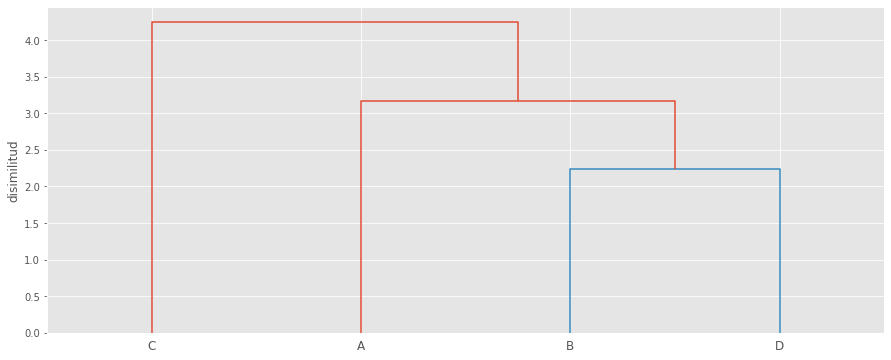

In [60]:
## Dendograma con method = "single", metric = "euclidean"
## El agrupamiento jerárquico codificado como una matriz de vinculación.
dendograma = sch.dendrogram(hc, labels = example.index)
plt.ylabel("disimilitud")
plt.show()

En el ***dendrograma*** que se muestra arriba, cada hoja corresponde a un registro, mientras nos movemos
arriba del árbol, los objetos que son similares entre sí se combinan en ramas, que se fusionan a una altura mayor.
La altura de la fusión, proporcionada en el eje vertical, indica la (dí)similitud/distancia
entre dos registros/clusters. Cuanto mayor sea la altura de la fusión, menos similaridad hay entre los cluster que se fusionan. Esta altura se conoce como la distancia ***cofenética*** entre los dos objetos.

Definamos varios métodos y metricas:

In [62]:
hc  = sch.linkage(example, method="single",   metric = "cityblock",)
hc1 = sch.linkage(example, method="complete", metric = "mahalanobis")
hc2 = sch.linkage(example, method="centroid", metric = "euclidean")
hc3 = sch.linkage(example, method="ward",     metric = "euclidean")

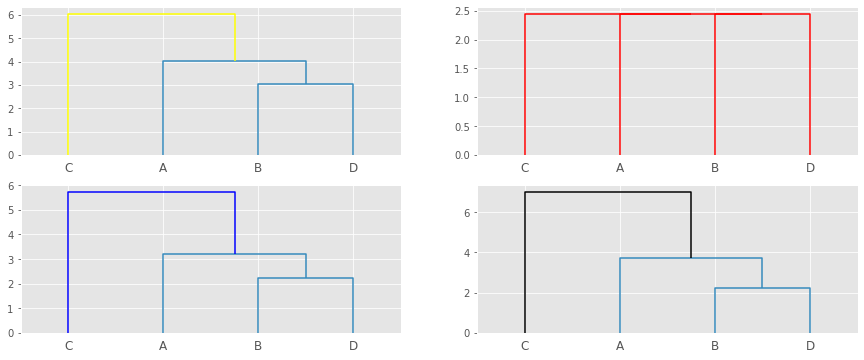

In [65]:
## Distintos dendogramas.
fig, axes = plt.subplots(2,2, sharex=True,)
###
sch.dendrogram(hc,  ax=axes[0,0], above_threshold_color="yellow", orientation="top",
               labels = example.index)
sch.dendrogram(hc1, ax=axes[0,1], above_threshold_color="red", labels = example.index)
sch.dendrogram(hc2, ax=axes[1,0], above_threshold_color="blue", color_threshold=4,
               labels = example.index)
sch.dendrogram(hc3, ax=axes[1,1], above_threshold_color="black",labels = example.index)
###
plt.show()

***Notas importante:*** 

1. Tenga en cuenta que, por lo general, se recomienda estandarizar las variables en el conjunto de datos antes
de realizar análisis posteriores. La estandarización hace que las variables sean comparables, cuando
se miden en diferentes escalas. Por ejemplo, una variable puede medir la altura en metros y otra variable puede medir el peso en kg.

2. El agrupamiento aglomerativo es el tipo más común de agrupamiento jerárquico. Úselo para agrupar registros en clusters en función de su similitud. También se le conoce como AGNES. (Anidamiento Aglomerativo). 

3. El clusterin aglomerativo funciona "de abajo hacia arriba". Es decir, cada objeto es inicialmente considerado como un cluster de un solo elemento (hoja). En cada paso del algoritmo, los dos clusters que son más similares se combinan en un nuevo cluster más grande
(nodos). Este procedimiento se repite hasta que todos los registros son miembros de un solo gran
clúster (raíz). El resultado es un árbol basado en la
representación de los registros, denominado ***dendograma.***

Tenga en cuenta que el agrupamiento aglomerativo es bueno para identificar pequeños grupos.

## ***Ejemplo 2.***

In [74]:
USArrests = pd.read_csv(url_base + "USArrests.csv", index_col=0)
USArrests.head()

,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [75]:
USArrests.describe().T

,count,mean,std,min,25%,50%,75%,max
Murder,50.0,7.788,4.355510,0.8,4.075,7.25,11.250,17.4
Assault,50.0,170.760,83.337661,45.0,109.000,159.00,249.000,337.0
UrbanPop,50.0,65.540,14.474763,32.0,54.500,66.00,77.750,91.0
Rape,50.0,21.232,9.366385,7.3,15.075,20.10,26.175,46.0


Recuerde que debemos estandarizar los datos.

In [76]:
scaler = StandardScaler()
scaler.fit(USArrests)
##
df = pd.DataFrame(scaler.transform(USArrests), columns = USArrests.columns, 
                  index = USArrests.index)
df.head(6)

,Murder,Assault,UrbanPop,Rape
Alabama,1.255179,0.790787,-0.526195,-0.003451
Alaska,0.513019,1.118060,-1.224067,2.509424
Arizona,0.072361,1.493817,1.009122,1.053466
Arkansas,0.234708,0.233212,-1.084492,-0.186794
California,0.281093,1.275635,1.776781,2.088814
Colorado,0.025976,0.402909,0.869548,1.883901


In [77]:
## Distancia Mahalanobis.
pd.DataFrame(cdist(df, df, "mahalanobis"), columns=df.index,index=df.index).iloc[0:6,0:6]

,Alabama,Alaska,Arizona,Arkansas,California,Colorado
Alabama,0.000000,4.419320,3.173451,1.424984,3.541993,3.365494
Alaska,4.419320,0.000000,3.893855,3.523499,3.577636,2.812180
Arizona,3.173451,3.893855,0.000000,2.713884,1.752951,2.660469
Arkansas,1.424984,3.523499,2.713884,0.000000,3.274534,2.898161
California,3.541993,3.577636,1.752951,3.274534,0.000000,1.439765
Colorado,3.365494,2.812180,2.660469,2.898161,1.439765,0.000000


In [78]:
## Distancia Euclidiana.
pd.DataFrame(cdist(df, df, "euclidean"), columns=df.index,index=df.index).iloc[0:6,0:6]

,Alabama,Alaska,Arizona,Arkansas,California,Colorado
Alabama,0.000000,2.731204,2.316805,1.302905,3.296239,2.677982
Alaska,2.731204,0.000000,2.728061,2.854730,3.043126,2.350139
Arizona,2.316805,2.728061,0.000000,2.745350,1.323789,1.378889
Arkansas,1.302905,2.854730,2.745350,0.000000,3.801851,2.859794
California,3.296239,3.043126,1.323789,3.801851,0.000000,1.300691
Colorado,2.677982,2.350139,1.378889,2.859794,1.300691,0.000000


In [79]:
hc = sch.linkage(df,                                  ### Dataset estandarizado
                 method="ward",                       ### Medida de similaridad entre cluster
                 metric="euclidean"                   ### Medida de similaridad entre individuos.
                 )   
hc[0:6,:]

array([[14.        , 28.        ,  0.2079438 ,  2.        ],
       [12.        , 31.        ,  0.35377437,  2.        ],
       [13.        , 15.        ,  0.43312429,  2.        ],
       [22.        , 48.        ,  0.49909939,  2.        ],
       [19.        , 30.        ,  0.54082482,  2.        ],
       [35.        , 52.        ,  0.55914837,  3.        ]])

In [72]:
#pd.DataFrame(USArrests.index, columns = ["state"])

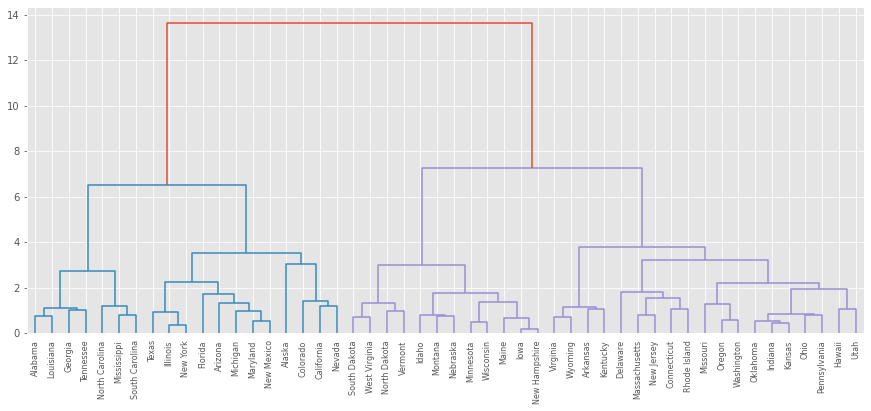

In [80]:
## dendogram
dendogram = sch.dendrogram(hc,labels=df.index,)

## ***Coeficiente aglomerativo.***

Después de vincular los objetos en un conjunto de datos en un árbol de ***clúster jerárquico***, es posible que se desee evaluar que las distancias (es decir, las alturas) en el árbol reflejan las distancias originales
de buena manera.

Una forma de medir qué tan bien el dendograma refleja los datos es calcular la ***correlación entre las distancias cofenéticas*** y los datos de distancia originales. Si la agrupación es válida, la vinculación de objetos en el árbol de clúster debe tener una fuerte correlación con las distancias entre objetos en la matriz de distancia original.

Cuanto más se acerque a 1 el valor del coeficiente de correlación, con mayor precisión será la solución de agrupamiento reflejada es sus datos. Los valores superiores a 0,75 se consideran buenos.

In [81]:
metricas = ["braycurtis", "canberra", "chebyshev", "cityblock", "correlation", "cosine",
            "euclidean", "jaccard","mahalanobis", "minkowski", "seuclidean", "sqeuclidean"]
metodos = ["single", "complete", "average", "weighted","centroid","median", "ward"]
### Depende de scipy 100%
cophenetic_coef(df, metodos, metricas)   

,single,complete,average,weighted,centroid,median,ward
braycurtis,0.45419,0.579994,0.587999,0.555646,-1,-1,-1
canberra,0.684276,0.711447,0.853879,0.829601,-1,-1,-1
chebyshev,0.554387,0.66185,0.678834,0.588439,-1,-1,-1
cityblock,0.54621,0.703594,0.71184,0.709585,-1,-1,-1
correlation,0.714172,0.734769,0.857805,0.72666,-1,-1,-1
cosine,0.796175,0.695941,0.804943,0.639452,-1,-1,-1
euclidean,0.541272,0.697944,0.718038,0.621264,0.715281,0.555451,0.697527
jaccard,0.460865,0.824278,0.871284,0.866515,-1,-1,-1
mahalanobis,0.675893,0.640368,0.714444,0.606974,-1,-1,-1
minkowski,0.541272,0.697944,0.718038,0.621264,-1,-1,-1


## ***Cortar el dendograma en diferentes grupos.***

Para identificar subgrupos, podemos cortar el ***dendrograma*** a cierta altura.  como se describe en las siguientes secciones.


Uno de los problemas con el agrupamiento jerárquico es que no nos dice cuántos clústeres hay, o dónde cortar el dendrograma para formar clusters.
Puede cortar el árbol jerárquico a una altura determinada para dividir los datos en clusters. Vamos a usar a [`sch.cut_tree()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.cut_tree.html) para esta tarea.

In [ ]:
## Seleccionar 4 clusters.
labels = sch.cut_tree(hc,n_clusters=4)
pd.DataFrame(labels, index = df.index, columns=["label"])#.head()

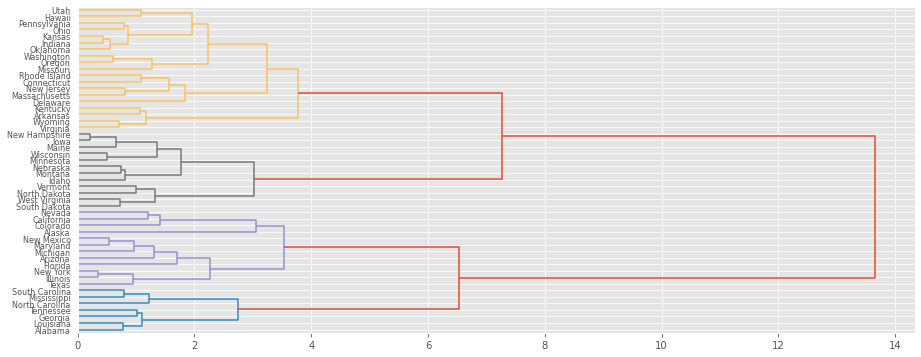

In [25]:
dendogram1 = sch.dendrogram(hc,                         ##  El agrupamiento jerárquico codificado 
                            labels=df.index,            ##  como una matriz de vinculación.
                            color_threshold=4,
                            orientation = "right"
                            )

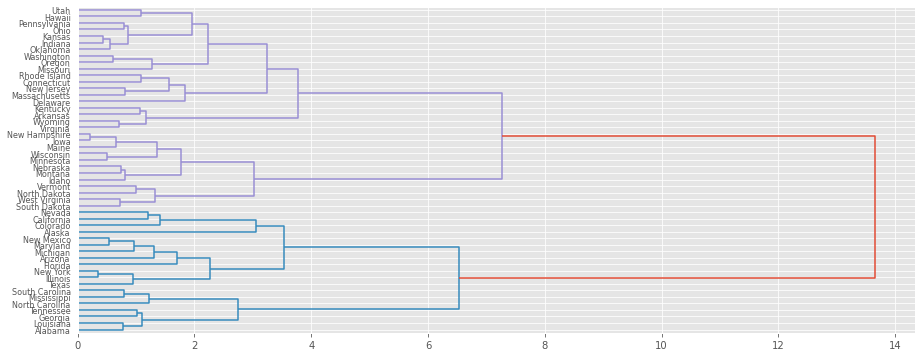

In [85]:
dendogram2 = sch.dendrogram(hc, labels=df.index, color_threshold=10, orientation = "right")

In [ ]:
## Seleccionar 2 clusters.
labels = sch.cut_tree(hc,n_clusters=2)
pd.DataFrame(labels, index = df.index, columns=["label"])#.head()

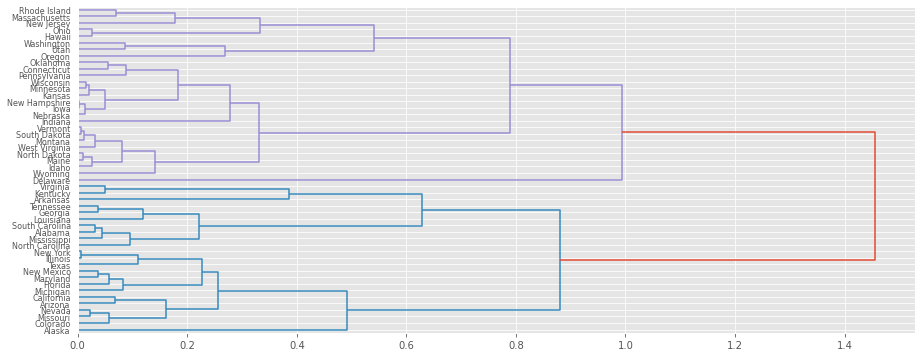

In [90]:
hc_def = sch.linkage(df, method="average", metric="cosine")
dendo_def = sch.dendrogram(hc_def, labels=df.index, orientation = "right",)# color_threshold=1.1)

In [ ]:
## DataFrame de trabajo posterior
df_end = USArrests.copy()
df_end["cluster"] = labels
df_end

# VAMOS ACÁ

In [29]:
## Opción para el número de cluster.
## Determinar la máxima distancia vertical que no se intersecta con ninguno de los otro grupos.
## Dibujar una linea horizontal en ambos extremos.
## El número de clusters es igual al número de lineas verticales que pasan por la recta horizontal.
cut_diff = pd.DataFrame(hc_def[:,2], columns = ["link_height"])
cut_diff["diff"] = cut_diff.diff(1)
cut_diff = cut_diff.fillna(0).sort_values(by=["diff"], ascending = False)
cut_diff.head()

,link_height,diff
48,1.455229,0.461014
45,0.788468,0.159465
47,0.994216,0.113933
42,0.490798,0.104382
46,0.880283,0.091815


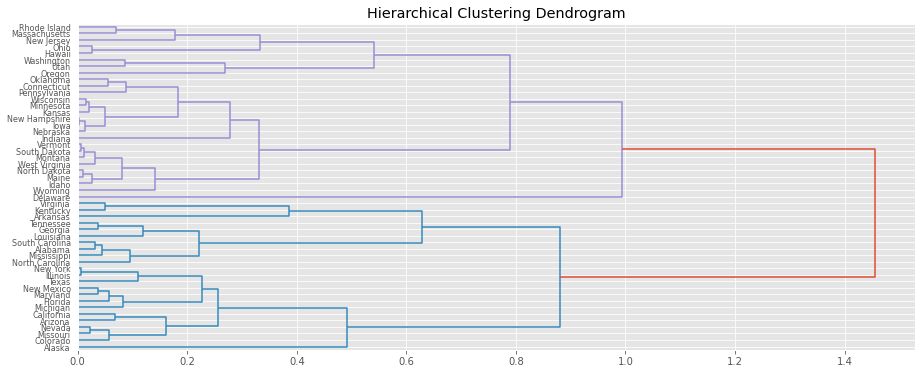

In [30]:
## Primera opción
### Punto 1 de corte.
point_cut1 = cut_diff.loc[cut_diff["diff"].idxmax(),"link_height"]
point_cut1

dendogram1 = sch.dendrogram(hc_def,                         ##  El agrupamiento jerárquico codificado 
                            labels=df.index,            ##  como una matriz de vinculación.
                            color_threshold = point_cut1,
                            orientation = "right"
                            )
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

0.7884684908073105


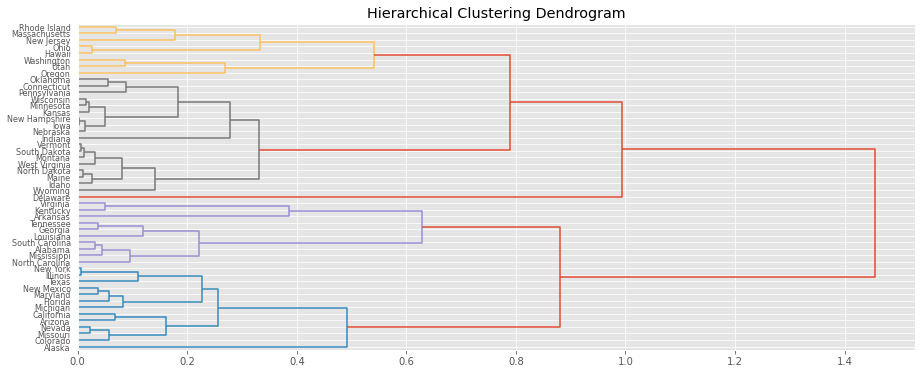

In [31]:
### Punto 2 de corte.
point_cut2 = cut_diff.loc[45,"link_height"]
print(point_cut2)
## Segunda opción
dendogram1 = sch.dendrogram(hc_def,                           ##  El agrupamiento jerárquico codificado 
                            labels=df.index,              ##  como una matriz de vinculación.
                            color_threshold = point_cut2,
                            orientation = "right"
                            )
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

## ***sklearn***

Vamos a usar [`AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) del módulo [`sklearn.cluster`](https://scikit-learn.org/stable/modules/clustering.html#)

In [32]:
%%capture
!pip install mglearn
import mglearn

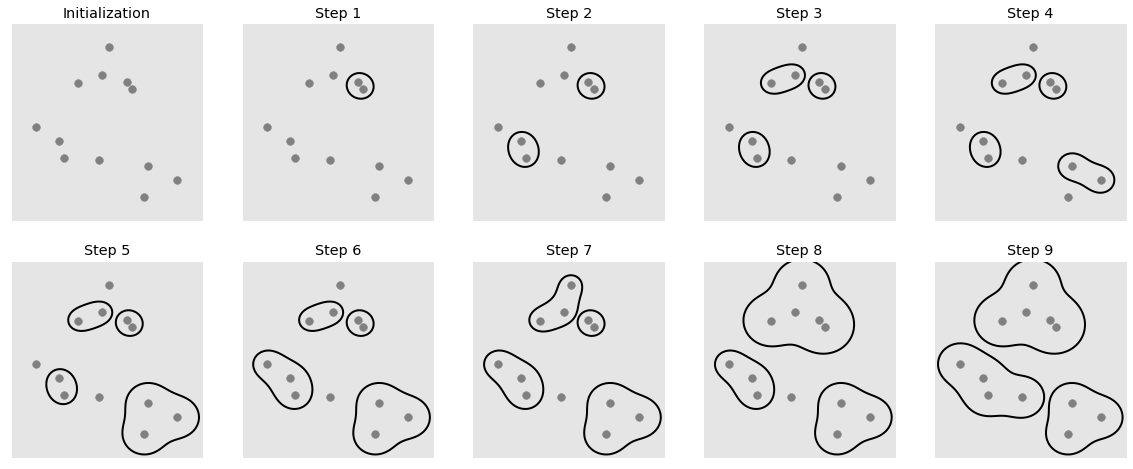

In [33]:
mglearn.plots.plot_agglomerative_algorithm()

In [34]:
## En AgglomerativeClustering tenemos los siguientes linkages:
## linkage: {"ward", "complete", "average", "single"}, default="ward"
## El criterio de vinculación (linkage) determina qué distancia usar entre conjuntos de observación.
## El algoritmo fusionará los pares de clústeres que minimizan este criterio.
## "ward": Minimiza la varianza de los grupos que se fusionan.
## "average": Usa el promedio de las distancias de cada observación de los dos conjuntos.
##  El enlace "complete" o "máximo" utiliza las distancias máximas entre todas las observaciones de 
## los dos conjuntos.
## "single": Utiliza el mínimo de las distancias entre todas las observaciones de los dos conjuntos.
linkages = ["ward","complete","average","single"]
## affinity: str or callable, default="euclidean"
## Metric used to compute the linkage. Can be “euclidean”, “l1”, “l2”, “manhattan”, “cosine”,
## or “precomputed”. If linkage is “ward”, only “euclidean” is accepted. If “precomputed”,
## a distance matrix (instead of a similarity matrix) is needed as input for the fit method.
affinitys = ["braycurtis", "canberra", "chebyshev","cityblock", "correlation", "cosine",
           "euclidean","jensenshannon", "mahalanobis","minkowski",]
## Haremos uso de esto para calcular las "mejores" elecciones:
cophenetic_coef(df, methods = linkages, metrics = affinitys)                

,ward,complete,average,single
braycurtis,-1,0.579994,0.587999,0.45419
canberra,-1,0.711447,0.853879,0.684276
chebyshev,-1,0.66185,0.678834,0.554387
cityblock,-1,0.703594,0.71184,0.54621
correlation,-1,0.734769,0.857805,0.714172
cosine,-1,0.695941,0.804943,0.796175
euclidean,0.697527,0.697944,0.718038,0.541272
jensenshannon,-1,-1,-1,-1
mahalanobis,-1,0.640368,0.714444,0.675893
minkowski,-1,0.697944,0.718038,0.541272


In [35]:
n_clusters = 2
cluster1 = AgglomerativeClustering(n_clusters = n_clusters,     # El número de clústeres a buscar.
                                   affinity="cosine",           # Métrica entre individuos.
                                   linkage="average",           # El criterio de vinculación.
                                   )
##
cluster1.fit(df)

AgglomerativeClustering(affinity='cosine', linkage='average')

In [36]:
## Atributos: n_clusters_, labels_
print(cluster1.n_clusters_)
print(cluster1.labels_)

2
[1 1 1 1 1 1 0 0 1 1 0 0 1 0 0 0 1 1 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 0 0 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0]


In [37]:
## Atributos: n_leaves_, n_connected_components_,
print(cluster1.n_leaves_)
print(cluster1.n_connected_components_)

50
1


In [38]:
## Atributos: n_features_in_, feature_names_in_,
print(cluster1.n_features_in_)
print(cluster1.feature_names_in_)

4
['Murder' 'Assault' 'UrbanPop' 'Rape']


In [39]:
##print(cluster1.children_)
##print(cluster1.distances_)

In [40]:
labels1 = cluster1.labels_
pd.DataFrame({"cluster1":labels1},index= df.index).value_counts()

cluster1
0           27
1           23
dtype: int64

In [41]:
## "Predicción del cluster"
cluster1.fit_predict(df)

array([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0])

In [42]:
## DataFrame final con las clasificaciones.
df["cluster"] = labels1; df.head()

,Murder,Assault,UrbanPop,Rape,cluster
Alabama,1.255179,0.790787,-0.526195,-0.003451,1
Alaska,0.513019,1.118060,-1.224067,2.509424,1
Arizona,0.072361,1.493817,1.009122,1.053466,1
Arkansas,0.234708,0.233212,-1.084492,-0.186794,1
California,0.281093,1.275635,1.776781,2.088814,1


In [43]:
################################################################################################
################################################################################################
################################################################################################

In [44]:
n_clusters=4
cluster2 = AgglomerativeClustering(n_clusters=n_clusters,
                                   affinity="euclidean",
                                   linkage="average")     
##
cluster2.fit(df)
labels2 = cluster2.labels_
labels2
pd.DataFrame({"cluster2":labels2},index= df.index).head()

,cluster2
Alabama,1
Alaska,2
Arizona,3
Arkansas,1
California,3


In [45]:
## DataFrame final con las clasificaciones.
df["cluster"] = labels2; df.head()

,Murder,Assault,UrbanPop,Rape,cluster
Alabama,1.255179,0.790787,-0.526195,-0.003451,1
Alaska,0.513019,1.118060,-1.224067,2.509424,2
Arizona,0.072361,1.493817,1.009122,1.053466,3
Arkansas,0.234708,0.233212,-1.084492,-0.186794,1
California,0.281093,1.275635,1.776781,2.088814,3


## ***Visualización de los cluster.***

Vamos a hacer uso de `PCA` para lograr visualizar los cluster.

In [46]:
df = df.drop("cluster", axis = 1)
pca = PCA(n_components=0.99)
pca.fit(df)
pca_array = pca.transform(df)

In [47]:
np.cumsum(pca.explained_variance_ratio_)

array([0.62006039, 0.86750168, 0.95664248, 1.        ])

In [48]:
n_clusters = 2
cluster1 = AgglomerativeClustering(n_clusters = n_clusters, affinity="cosine", linkage="average",)
cluster1.fit(df)
## Cluster de cada registro.
labels1 = cluster1.labels_

In [49]:
## Plot con 2 clusters.
cluster_biplot(pca,USArrests,labels1,size_text=5)

In [50]:
## Con 4 clusters
n_clusters = 4
cluster2 = AgglomerativeClustering(n_clusters = n_clusters, affinity="cosine", linkage="average",)
cluster2.fit(df)

AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=4)

In [51]:
## Cluster de cada registro.
labels2 = cluster2.labels_
## Plot con 4 clusters.
cluster_biplot(pca,USArrests,labels2,size_text=6.5)

## ***Ventajas y desventajas de la agrupación jerárquica***

1. No se necesita especificar el número de clusters necesarios para el algoritmo.

2. No funciona bien en los conjuntos de datos grandes. En general, es aplicable a los  pequeños. 

3.  En comparación con K-means, el clustering jerárquico es computacionalmente pesado y tarda más tiempo en ejecutarse.




## ***Conclusión.***
A pesar de las limitaciones del clustering jerárquico cuando se trata de grandes conjuntos de datos, sigue siendo una gran herramienta para tratar con conjuntos de datos pequeños y medianos y encontrar patrones en ellos. 

## ***Referencias:***

1. _Análisis estadístico de datos multivariados. Díaz L & Morales M. Editorial: Publicaciones Facultad de ciencias. UNAL._

2. _Multivariate Analysis I. Kassambara A. Disponible en: http://www.sthda.com/english/_